In [2]:
from __future__ import print_function
import os
import nltk
import re
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import vocabulary
import newsreader
import scipy
import sklearn
import os
import lda
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from gensim import corpora, models
from sklearn.manifold import TSNE
from sklearn.metrics import jaccard_similarity_score
try:
    import cPickle as pickle
except:
    import pickle
from sklearn.datasets.twenty_newsgroups import \
     strip_newsgroup_header as strip_newsgroup_header
from sklearn.datasets.twenty_newsgroups import \
     strip_newsgroup_quoting as strip_newsgroup_quoting
from sklearn.datasets.twenty_newsgroups import \
     strip_newsgroup_footer as strip_newsgroup_footer
from sklearn.metrics.pairwise import linear_kernel
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
matplotlib.rcParams['figure.figsize'] = (10,10)

C:\Users\varni\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Step1 - part(a):

Lets define our file path and take two articles which have similar

In [3]:
vocab_file, vocab_file_type = "reviews-vocab.pkl", "pickle"

embedding_file, embedding_dimensions, embedding_cache = "D:/Rutgers/4th-Semester/Natural_Language_Processing/glove.6B/glove.6B.50d.txt", 50, "newsgroup-embedding.npz"

all_data, train_dir, dev_dir, test_dir = "D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1","D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1/20news-bydate-train/", None ,"D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1/20news-bydate-test/" 
    
class1, class2 = "comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware"

has_bad_metadata = True

In [4]:
made_vocabulary = False
if made_vocabulary :
    v = vocabulary.Vocabulary.load(vocab_file, file_type=vocab_file_type)
else: 
    tokens = newsreader.all_textfile_tokens(all_data, strip_metadata=has_bad_metadata)                                            
    v = vocabulary.Vocabulary.from_iterable(tokens, file_type=vocab_file_type)
    v.save(vocab_file)
v.stop_growth()

In [5]:
made_embedding = False
if made_embedding :
    e = newsreader.load_sparse_csr(embedding_cache)
else: 
    e = newsreader.build_sparse_embedding(v, embedding_file, embedding_dimensions)
    newsreader.save_sparse_csr(embedding_cache, e)

140907 words were not in glove


In [6]:
targets = []
def selected(name) :
    if not targets:
        return True
    if any(t.startswith(name) for t in targets) :
        return True
    return False

In [7]:
def use_default_features(vocab) :
    return lambda data: vocab

def count_features(features, gen_tokens) :
    for t in gen_tokens :
        r = features.add(t)
        if r :
            yield r    
            
count_data = newsreader.DataManager(train_dir + class1,
                                       train_dir + class2,
                                       test_dir + class1,
                                       test_dir + class2,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class1 if dev_dir else None,
                                       dev_dir + class2 if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

count_data.initialize(build_cache=True)

In [8]:
def make_boolean_features(feature_counter) :
    def collect_features(features, gen_tokens) :
        seen = set()
        for f in feature_counter(features, gen_tokens) :
            seen.add(f)
        for f in seen :
            yield f
    return collect_features

boolean_data = newsreader.DataManager(train_dir + class1,
                                         train_dir + class2,
                                         test_dir + class1,
                                         test_dir + class2,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class1 if dev_dir else None,
                                         dev_dir + class2 if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

boolean_data.initialize(build_cache=True)

In [9]:
class Experiment(object) :
    '''Organize the process of getting data, building a classifier,
    and exploring new representations'''
    
    def __init__(self, data, comment, classifier, cdesc) :
        'set up the problem of learning a classifier from a data manager'
        self.data = data
        self.comment = comment
        self.classifier = classifier
        self.cdesc = cdesc
        self.initialized = False
        
    def initialize(self) :
        'materialize the training data, dev data and test data as matrices'
        if not self.initialized :
            self.train_X, self.train_y = self.data.training_data()
            self.dev_X, self.dev_y = self.data.dev_data()
            self.test_X, self.test_y = self.data.test_data()
            self.initialized = True
        
    def fit_and_validate(self, report=True) :
        'train the classifier and assess predictions on dev data'
        if not self.initialized :
            self.initialize()
        self.classifier.fit(self.train_X, self.train_y)
        self.dev_predictions = self.classifier.predict(self.dev_X)
        self.accuracy = sklearn.metrics.accuracy_score(self.dev_y, self.dev_predictions)
        if report :
            print("{}\nclassified by {}\naccuracy {}".format(self.comment, self.cdesc, self.accuracy))
            
    def xval(self, folds=20, report=True) :
        accuracies = []
        for i in range(folds) :
            self.fit_and_validate(report=False)
            accuracies.append(self.accuracy)
        if report :
            msg = "{}\nclassified by {}\naverage accuracy {} (std {})"
            print(msg.format(self.comment, self.cdesc, 
                             sum(accuracies)/folds,
                             np.std(accuracies)))
    
    @classmethod
    def transform(cls, expt, operation, description, classifier, cdesc) :
        'use operation to transform the data from expt and set up new classifier'
        if not expt.initialized :
            expt.initialize()
        result = cls(expt.data, expt.comment + '\n' + description, classifier, cdesc)
        result.train_X, result.train_y = operation(expt.train_X, expt.train_y, 'train')
        result.dev_X, result.dev_y = operation(expt.dev_X, expt.dev_y, 'dev')
        result.test_X, result.test_y = operation(expt.test_X, expt.test_y, 'test')
        result.initialized = True
        return result
        

In [10]:
if selected("expt_10_"):
    expt_10_ = Experiment(count_data,
                       "{}: {} vs {}, using word count features".format(all_data, class1, class2),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                       "logistic regression")
    expt_10_.initialize()
    expt_10_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: comp.sys.ibm.pc.hardware vs comp.sys.mac.hardware, using word count features
classified by logistic regression
average accuracy 0.7831632653061223 (std 0.012019611213663003)


In [11]:
if selected("expt_11_") :
    expt_11_ = Experiment(boolean_data,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class1, class2),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                         "logistic regression")
    expt_11_.initialize()
    expt_11_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: comp.sys.ibm.pc.hardware vs comp.sys.mac.hardware, using word presence/absence features
classified by logistic regression
average accuracy 0.8081632653061226 (std 0.013822670596065382)


We setup the experiment to look at two kinds of newsgroups we believe maybe matching. I considered newsgroups - **comp.sys.ibm.pc.hardware** and **comp.sys.mac.hardware**. Both these topics talk about computer hardware but about two different firms, I hypothesize the assumption that classifier may find it hard to explain the difference amongst them. We tried (word count features) vs (word presence/absence features) we  get 78.5% vs 81.58% accuracy on the test.

## Step1 - part(b):

In [12]:
class1, class2 = "soc.religion.christian", "rec.autos"

In [13]:
def use_default_features(vocab) :
    return lambda data: vocab

def count_features(features, gen_tokens) :
    for t in gen_tokens :
        r = features.add(t)
        if r :
            yield r    
            
count_data = newsreader.DataManager(train_dir + class1,
                                       train_dir + class2,
                                       test_dir + class1,
                                       test_dir + class2,
                                       use_default_features(v),
                                       count_features,
                                       dev_dir + class1 if dev_dir else None,
                                       dev_dir + class2 if dev_dir else None,
                                       strip_metadata=has_bad_metadata)

count_data.initialize(build_cache=True)

In [14]:
if selected("expt_10_"):
    expt_10_ = Experiment(count_data,
                       "{}: {} vs {}, using word count features".format(all_data, class1, class2),
                       sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                       "logistic regression")
    expt_10_.initialize()
    expt_10_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: soc.religion.christian vs rec.autos, using word count features
classified by logistic regression
average accuracy 0.8893939393939394 (std 0.010937579710963489)


In [15]:
def make_boolean_features(feature_counter) :
    def collect_features(features, gen_tokens) :
        seen = set()
        for f in feature_counter(features, gen_tokens) :
            seen.add(f)
        for f in seen :
            yield f
    return collect_features

boolean_data = newsreader.DataManager(train_dir + class1,
                                         train_dir + class2,
                                         test_dir + class1,
                                         test_dir + class2,
                                         use_default_features(v),
                                         make_boolean_features(count_features),
                                         dev_dir + class1 if dev_dir else None,
                                         dev_dir + class2 if dev_dir else None,
                                         strip_metadata=has_bad_metadata)

boolean_data.initialize(build_cache=True)

In [16]:
if selected("expt_11_") :
    expt_11_ = Experiment(boolean_data,
                         "{}: {} vs {}, using word presence/absence features".format(all_data, class1, class2),
                         sklearn.linear_model.SGDClassifier(loss="log",
                                       penalty="elasticnet",
                                       max_iter=50),
                         "logistic regression")
    expt_11_.initialize()
    expt_11_.xval()

D:/Rutgers/4th-Semester/Natural_Language_Processing/Homework-1: soc.religion.christian vs rec.autos, using word presence/absence features
classified by logistic regression
average accuracy 0.8994949494949497 (std 0.01372957294855373)


The part(b) of this analysis takes into picture two disimilar newgroups and we compare their accuracy. They seem to perform well in comparison to the previous step. The accuracy of this model is **88.7% (word count features)** vs **89.5% (word absence/ presence features)**.

## Step2 - Lets measure document similarity

I am setting up an experiment to check newsgroup similarity and visualize this using some heat maps. I am assuming newsgroups which talk about religion to be similar, groups talking about technology also to be similar and etc. The least similar newsgroup I assume shall be 'misc.forsale'.

## Step3 - Setting up the experiment

We assume documents in every newsgroup as a large corpus. We split the words and apply tf-idf algorithm to it. Once this is done
a dot product between the two gives the cosine similarity between the newsgroup. Another method is to reduce the dimension
and check the similarity. Jaccard similarity was also taken into consideration, which measures the number of common words betwee, two documents.

## Step4 - Running the experiment

In [17]:
path = 'D:/Rutgers/4th-Semester/Natural_Language_Processing/20-Newsgroup/'

In [18]:
news_group_collection = dict()
complete_text =[]

for name in os.listdir(path):
    
    path_new = os.path.join(path, name)
    text_list =[]
    for fname in sorted(os.listdir(path_new)):
        path_fname = os.path.join(path_new, fname)
        with open(path_fname,encoding='latin-1') as f:
            text = f.read()
            text = strip_newsgroup_footer(
            strip_newsgroup_quoting(
            strip_newsgroup_header(text)))
            text = re.sub(r'[^\x00-\x7F]+', ' ', text)
            text = re.sub(r'\n\n',' ',text)
            text = re.sub(r'\n',' ',text)
            text_list.append(text)
            complete_text.append(text)
    news_group_collection[name] = text_list     
            

In [19]:
news_group = dict()
news_data= []
for k,v in news_group_collection.items():
    str1 = ''.join(str(e) for e in v)
    news_data.append(str1)
    news_group[k] = str1

In [20]:
tfidf = TfidfVectorizer(stop_words='english').fit_transform(news_data)

In [21]:
cosine_similarities = linear_kernel(tfidf[0:20], tfidf)

In [22]:
cosine_similarities_dt = pd.DataFrame(cosine_similarities)

In [23]:
headers = list(news_group.keys())
print(headers)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [24]:
def ploting(data_st,X):
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.25,left=0.25)
    heatmap = ax.pcolor(data_st)
    cbar = plt.colorbar(heatmap)
    ax.set_xticks(np.arange(data_st.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data_st.shape[0]) + 0.5, minor=False)
    ax.set_xticklabels(headers,rotation=90)
    ax.set_yticklabels(headers)
    ax.set_title(X)
    plt.show()

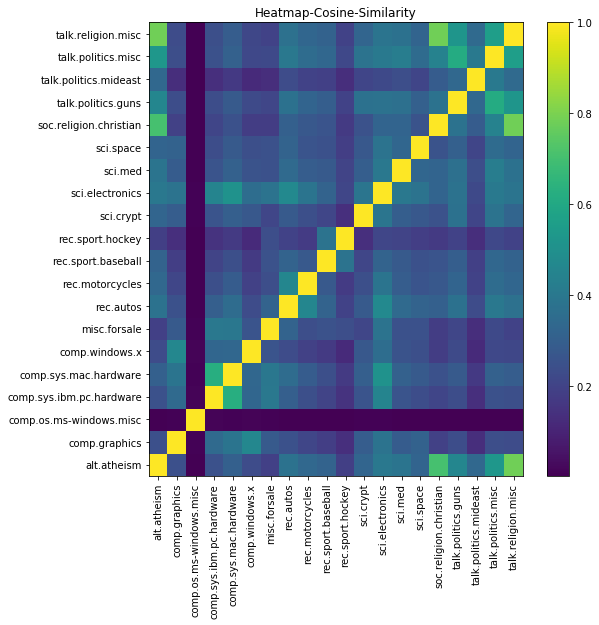

In [25]:
ploting(cosine_similarities_dt,'Heatmap-Cosine-Similarity')

In [26]:
def dimension_reduction(components,iterations):
    lsa = TruncatedSVD(n_components = components, algorithm = 'randomized', n_iter = iterations)
    dtm_lsa = lsa.fit_transform(tfidf)
    dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)
    return dtm_lsa

In [27]:
dtm_lsa = dimension_reduction(10,5)

In [28]:
lsa_similarities = linear_kernel(dtm_lsa[0:20], dtm_lsa)

In [29]:
lsa_similarities_dt = pd.DataFrame(lsa_similarities)

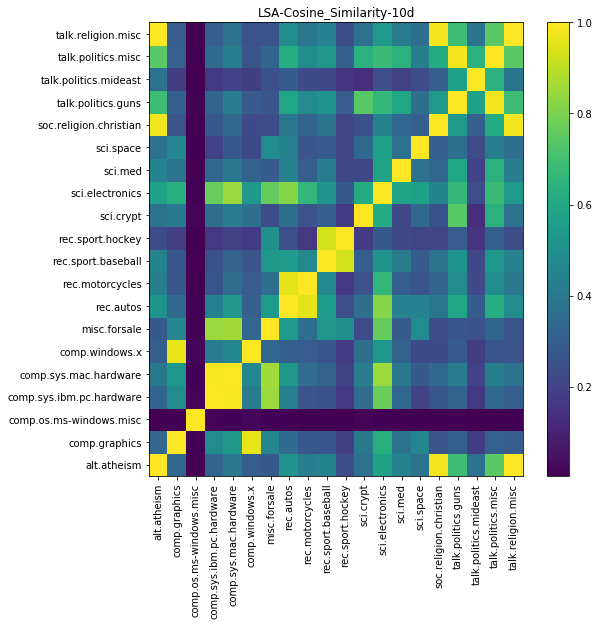

In [30]:
ploting(lsa_similarities_dt,'LSA-Cosine_Similarity-10d')

In [31]:
dtm_lsa = dimension_reduction(20,5)

In [32]:
lsa_similarities = linear_kernel(dtm_lsa[0:20], dtm_lsa)

In [33]:
lsa_similarities_dt = pd.DataFrame(lsa_similarities)

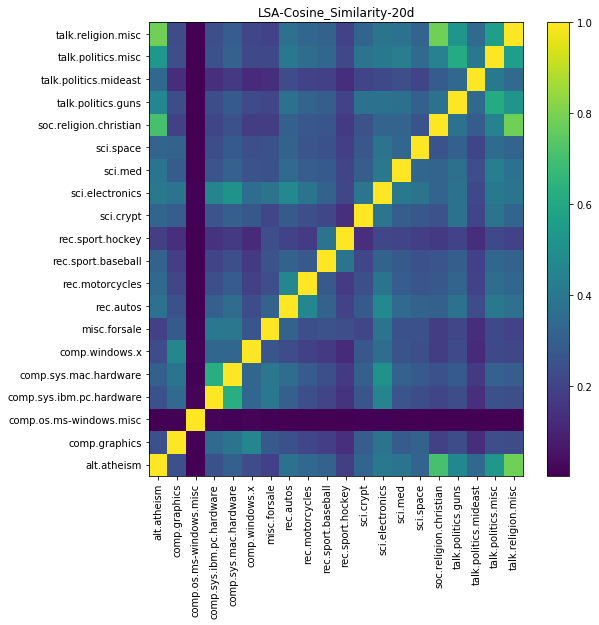

In [34]:
ploting(lsa_similarities_dt,'LSA-Cosine_Similarity-20d')

## Try finding all pairs of newsgroup with similarity (>.5):

In [35]:
cosine_sim_top = cosine_similarities_dt.applymap(lambda x : x if x > .5 else .49)

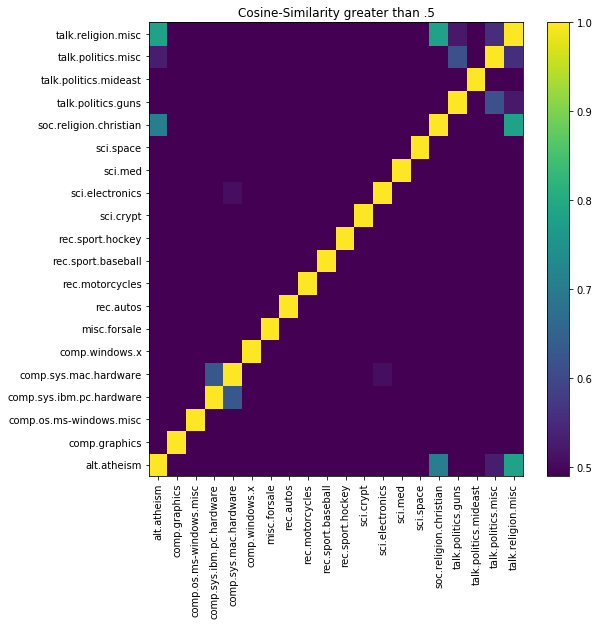

In [36]:
ploting(cosine_sim_top,'Cosine-Similarity greater than .5')

So we have heatmaps which of cosine similarity without dimension reduction.The plot does supoort our hypothesis to an extent matching newsgroups. We see similarity in terms of religion, sports, auto. However 'comp.misc.windows' seems to be poorly similar to all newgroup. I would be interested to see why this is happening. I shall explore more of this in my later analysis. On reducing dimensions using SVD, we are able to remove noise patterns from the data and the heatmap shows more similarity.Increasing the dimensions only leads to the heatmap being very similar to the cosine-similarity without dimension reduction.

## Jaccard Similarity

In [38]:
# news_tokens = dict()
# for k,v in news_group_collection.items():
#     set_words = set()
#     for i in range(len(v)):
#         t = v[i].split()
#         for words in t:
#             if words not in stopwords.words('english'):
#                 set_words.add(words)
#     news_tokens[k] = set_words

In [39]:
# pickle.dump(news_tokens, open('dictionary_tokens.p','wb'))
with (open("dictionary_tokens.p", "rb")) as openfile:
    news_tokens = pickle.load(openfile)  

In [40]:
jaccard_final = []
for k,v in news_tokens.items():
    jc = []
    for j in news_tokens.values():
        intr = len(v.intersection(j))
        uni = len(v.union(j))
        jaccard_score = intr/uni
        jc.append(jaccard_score)
    jaccard_final.append(jc)

In [41]:
jaccard_final_dt = pd.DataFrame(np.array(jaccard_final))

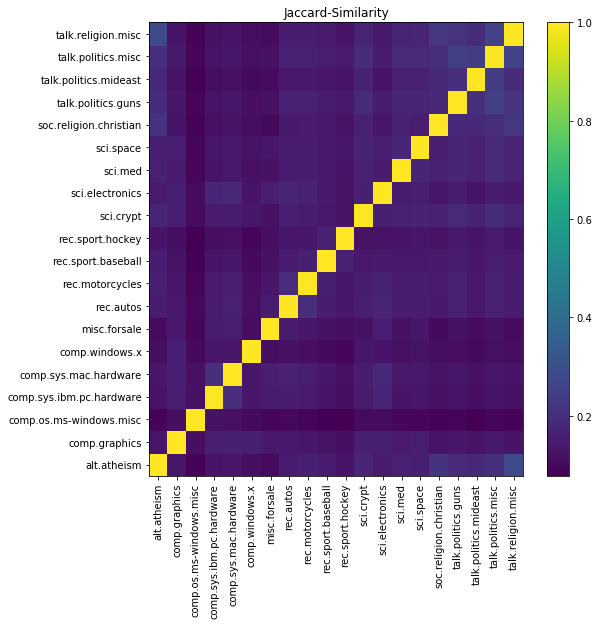

In [42]:
ploting(jaccard_final_dt,'Jaccard-Similarity')

Jaccard similarity shows poor similarity, I partly blame this on poor data. The kind of text I had after cleaning this data,needed some lemmatization and stemming. This could have given better results. One needs to note that the all these methods do not consider semantic similarity. Doc2Vec which projects documents in vector space is a fine method.